# AnimeGM - Autoencoder - Keras
GOAL: Generate new anime-style images
    
Methodology:
1. Build a dataset of images suitable for out needs
2. Build a generative model.
3. Train the model
4. Generate a new image with random numbers
5. Transfer style to a photo
6. Examine results

## 1. Build a dataset
Pull in an existing dataset and modify it for my needs.

Lets start with the danbooru 2017 anime image dataset. Now this dataset is huge. So we are only going to use 1 torrent of the SFW subset.

### Imports

In [1]:
import pandas as pd
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import seaborn as sns; sns.set()
from skimage.transform import resize
from os import listdir
from os.path import join
from skimage import data
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
%matplotlib inline

### Functions

In [2]:
# tf image preprocessing
# load, decoded and resize
def parse_image(image_path):
    image_string = tf.read_file(image_path)
    
    # decode
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # check for 1 channel
    # if so, grayscale
    if (n_channels == 1):
        image = tf.image.rgb_to_grayscale(image)
        
    # resize the image
    image = tf.image.resize_images(image, [resize_dim, resize_dim])
    
    # feature normalize the image
    image = tf.divide(image, 255)
    
    # check if we want the image flattened
    # if so, flatten the image
    if flatten == True:
        image = tf.reshape(image, [-1])
    
    return image

In [3]:
def show_image(image):
    # check for 1 channel
    # if so, grayscale
    if (n_channels == 1):
        image = image.reshape((resize_dim, resize_dim))
    else:
        image = image.reshape((resize_dim, resize_dim, n_channels))

    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
def show_images(images, figsize=(10, 10)):
   # get the number of images
    n_images = images.shape[0]
    
    if n_images == 1:
        show_image(images[0])
        return
    
    # get the square root of the number of images
    squareroot = int(np.ceil(np.sqrt(n_images)))
    
    fig, ax = plt.subplots(squareroot, squareroot, figsize=figsize,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, axi in enumerate(ax.flat):
        # exit if the index of subplots is greater than amount of images
        if i > n_images - 1:
            return
        
        image = images[i]
        
        # check for 1 channel
        # if so, grayscale
        if (n_channels == 1):
            image = image.reshape((resize_dim, resize_dim))
        else:
            image = image.reshape((resize_dim, resize_dim, n_channels))

        im = axi.imshow(image, cmap='gray')

### Variables

In [5]:
dir_name = 'danbooru-small'

In [6]:
n_train = 2200
n_test = 10

resize_dim = 32
n_channels = 1
n_features = resize_dim * resize_dim * n_channels

In [7]:
# hyper parameters~~~~
batch_size = 50
n_batches = int(n_train / batch_size)
n_epochs = 10

In [8]:
flatten = False
log_dir = '/Users/Admin/data-science/animeGM/autoencoder'

### Prepare data

In [9]:
# get filenames and join paths as np array
base_filenames = listdir(dir_name)
filename_paths = [join(dir_name, base_filename) for base_filename in base_filenames]
filename_paths = np.array(filename_paths)

In [10]:
# create paths for train and test
train_paths = filename_paths[:-n_test][:n_train]
test_paths = filename_paths[:n_test]

In [11]:
# reset the current graph and start over
reset_default_graph()

In [12]:
# create a dataset from the paths
image_paths = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(parse_image)
dataset = dataset.shuffle(buffer_size=n_train)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

# iterators
iter = dataset.make_initializable_iterator()
next_ele = iter.get_next()

(32, 32, 1)


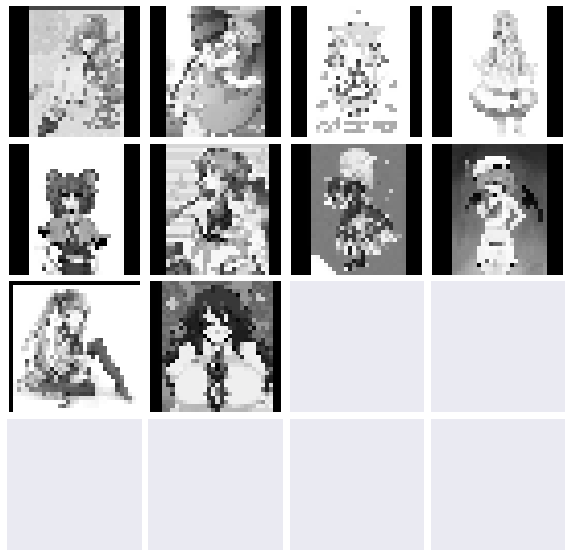

In [13]:
sess = tf.Session()

# Initialize an iterator over a testing dataset.
sess.run(iter.initializer, feed_dict={image_paths: test_paths})
    
# get batch
test_batch_X = sess.run(next_ele)

print(test_batch_X[0].shape)

# show the test images
show_images(test_batch_X)

## 2. Build a generative model
Lets build an autoencoder

In [14]:
import keras
from keras import backend as K
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, Reshape, UpSampling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [15]:
# input placeholder
inputs = Input(shape=(resize_dim, resize_dim, n_channels))

# encoded the input with convolutions and pooling
x = Conv2D(16, (3, 3), activation='relu', name='encoder_0', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same', name='pool_0')(x)
x = Conv2D(8, (3, 3), activation='relu', name='encoder_1', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool_1')(x)
x = Conv2D(8, (3, 3), activation='relu', name='encoder_2', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='pool_2')(x)

# decoded the compression and upsampling
x = Conv2D(8, (3, 3), activation='relu', name='decoder_0', padding='same')(encoded)
x = UpSampling2D((2, 2), name='upsample_0')(x)
x = Conv2D(8, (3, 3), activation='relu', name='decoder_1', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_1')(x)
x = Conv2D(16, (3, 3), activation='relu', name='decoder_2', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_2')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', name='decoder_3', padding='same')(x)

In [16]:
# this model maps inputs to its reconstructions
autoencoder = Model(inputs, decoded)

In [17]:
# this model maps inputs to encoded represations
# encoder = Model(inputs, encoded)

In [18]:
# create a placeholder for an ancoded input
# encoded_input = Input(shape=(32,))

# get the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-4]

# create decoder model
# decoder = Model(encoded_input, decoder_layer(encoded_input))

### Compile the model with cost and optimizer

In [19]:
autoencoder.compile(loss='binary_crossentropy', 
              optimizer='adadelta')

## 3. Train the model

In [20]:
# create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
# Initialize an iterator over a training dataset.
sess.run(iter.initializer, feed_dict={image_paths: train_paths})
    
for epoch_i in range(n_epochs):
    for batch_i in range(n_batches):
        # get batch
        batch_X = sess.run(next_ele)

        # train
        autoencoder.fit(batch_X, batch_X, 
                        epochs=1, batch_size=batch_size,
                        callbacks=[TensorBoard(log_dir=log_dir)])

In [ ]:
# Initialize an iterator over a testing dataset.
sess.run(iter.initializer, feed_dict={image_paths: test_paths})
    
# get batch
test_batch_X = sess.run(next_ele)

# show the test images
show_images(test_batch_X)

# create reconstructions
reconstructions = autoencoder.predict(test_batch_X)

# show the reconstructioned test images
show_images(reconstructions)